## Generative Adversarial Networks (GANs)

Выберите датасет, на котором хотите обучать вашу генеративную модель:
- CelebA: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
- PeopleArt: https://www.kaggle.com/datasets/amanagr/people-art-dataset
- Best Artworks of All Time: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
- Cartoon Faces (Google's Cartoon Set): https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set

Перед началом ознакомьтесь с https://github.com/soumith/ganhacks, советы оттуда можно использовать при выполнении заданий, особенно в задании 4

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
from pathlib import Path
from typing import Callable, cast

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable

In [3]:
class ImageDataset(Dataset):
    def __init__(
        self,
        datadir: Path,
        transform: Callable[[Image.Image], Tensor],
        pattern: str = "*.jpg",
    ) -> None:
        self.images = list(datadir.rglob(pattern))
        self.transform = transform

    def __getitem__(self, index) -> Tensor:
        img = Image.open(self.images[index])
        return self.transform(img)

    def __len__(self) -> int:
        return len(self.images)

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [5]:
# если работаете локально или в Google Colab, укажите правильный путь до папки с изображениями
# datadir = Path("/kaggle/input/celeba-dataset/img_align_celeba")
datadir = Path("img_align_celeba")
dataset = ImageDataset(
    datadir,
    transform=transform,
)
print(len(dataset))
print(dataset[0].shape)

202599
torch.Size([3, 64, 64])


In [6]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(loader))
print(batch.shape)

torch.Size([16, 3, 64, 64])


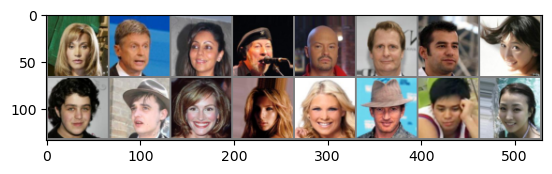

In [7]:
img_grid = torchvision.utils.make_grid(
    tensor=batch,
    nrow=8,
    padding=2,
    normalize=False,
)

plt.imshow(
    torchvision.transforms.ToPILImage()(
        img_grid * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    )
)

#### Задание 1 (2 балла). Завершите реализацию GAN

Реализуйте методы `generator_step` и `discriminator_step` в классе `GAN` с последней [практики](../workshops/12_gan.ipynb)

In [20]:
class GAN(L.LightningModule):
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        discriminator_period: int = 5,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.discriminator_period = discriminator_period

        # NB: у нас 2 оптимизатора, поэтому обновлять параметры будем вручную
        self.automatic_optimization = False

    def generate(self, n: int) -> Tensor:
        # Генерируем n изображений из случайного шума
        device = next(self.generator.parameters()).device
        latent_size, *_ = next(self.generator.parameters()).data.shape
        z = torch.randn(n, latent_size, 1, 1, device=device)
        return self.generator(z)

    def training_step(self, batch: Tensor, batch_idx: int) -> None:
        # Шаг генератора
        self.generator_step(batch)

        # Шаг дискриминатора
        if batch_idx % self.discriminator_period == 0:
            self.discriminator_step(batch)

    def configure_optimizers(self):
        # наши 2 оптимизатора: один для параметров генератора, другой — для параметров дискриминатора
        gen_opt = torch.optim.Adam(
            self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)
        )
        dis_opt = torch.optim.Adam(
            self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
        )
        return [gen_opt, dis_opt]

    def generator_step(self, batch: Tensor) -> None:
        optimizer_g, _ = self.optimizers(use_pl_optimizer=True)

        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_g`
        self.toggle_optimizer(optimizer_g)

        # Генерируем батч изображений-----------------------------------------------------------------------------------------------------------------------------
        fake = self.generate(batch.size(0))

        # Получаем оценку дискриминатора для `fake`---------------------------------------------------------------------------------------------------------------
        fake_scores = self.discriminator(fake)
        # Считаем ошибку генератора-------------------------------------------------------------------------------------------------------------------------------
        #valid_fake = torch.ones_like(fake_scores)
        #valid_fake = Variable(Tensor(batch.size(0), 1).fill_(1.0), requires_grad=False)
        #U = nn.BCELoss()
        #g_loss = U(fake_scores, valid_fake)
        g_loss = F.binary_cross_entropy_with_logits(fake_scores, torch.ones_like(fake_scores))

        # Обновляем параметры генератора
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()

        # Восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)
        self.untoggle_optimizer(optimizer_g)

        self.log("g_loss", g_loss, prog_bar=True)

    def discriminator_step(self, batch: Tensor) -> None:
        _, optimizer_d = self.optimizers(use_pl_optimizer=True)

        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_d`
        self.toggle_optimizer(optimizer_d)

        # Считаем ошибку дискриминатора на реальных изображениях---------------------------------------------------------------------------------------------------
        real_scores = self.discriminator(batch)
        #valid_real = torch.ones_like(real_scores)
       # valid_real = Variable(Tensor(batch.size(0), 1).fill_(1.0), requires_grad=False)
        #U = nn.BCELoss()
        #real_loss = U(real_scores, valid_real)
        real_loss = F.binary_cross_entropy_with_logits(real_scores, torch.ones_like(real_scores))

        # Считаем ошибку дискриминатора на сгенерированных изображениях--------------------------------------------------------------------------------------------
        fake = self.generate(batch.size(0))
        fake_scores = self.discriminator(fake)
        #valid_fake = torch.zeros_like(fake_scores)
        #valid_fake = Variable(Tensor(batch.size(0), 1).fill_(0.0), requires_grad=False)
        #fake_loss = U(self.discriminator(fake).detach(), valid_fake)
        fake_loss = F.binary_cross_entropy_with_logits(self.discriminator(fake.detach()), torch.zeros_like(fake_scores))

        # Обновляем параметры дискриминатора
        d_loss = 0.5 * (real_loss + fake_loss)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()

        # восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)
        self.untoggle_optimizer(optimizer_d)

        self.log("real_loss", real_loss, prog_bar=True)
        self.log("fake_loss", fake_loss, prog_bar=True)

    def on_train_epoch_end(self) -> None:
        images = self.generate(16)
        grid = torchvision.utils.make_grid(
            tensor=images,
            nrow=8,
            padding=2,
            normalize=True,
            value_range=(-1, 1),
        )
        str_title = f"{self.__class__.__name__}_images"
        logger = cast(TensorBoardLogger, self.logger)
        logger.experiment.add_image(str_title, grid, global_step=self.global_step)

In [21]:
class Generator(nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

        self.conv1 = nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.conv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 2)
        self.conv4 = nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 8)
        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        x = self.conv5(x).view(-1, 1)
        return x

#### Задание 2 (4 баллов). Базовое обучение

Запустите обучение модели
- минимальное кол-во шагов: 50000 (например 50 эпох по 1000 батчей в каждой)
- минимальный размер батча: 32 (можете увеличить, если не наблюдаете при этом кратной просадки по скорости)
- в конце обучения сгенерируйте 64 изображения

In [22]:
generator = Generator(latent_size=256)
discriminator = Discriminator()

trainer = L.Trainer(
    accelerator="gpu",
    max_epochs=50,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,
)

lit = GAN(generator, discriminator, discriminator_period=3)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model=lit, train_dataloaders=loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 2.8 M 
1 | generator     | Generator     | 4.9 M 
------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.481    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s, v_num=3, g_loss=1.320, real_loss=0.0322, fake_loss=0.457]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1000/1000 [03:46<00:00,  4.42it/s, v_num=3, g_loss=1.320, real_loss=0.0322, fake_loss=0.457]


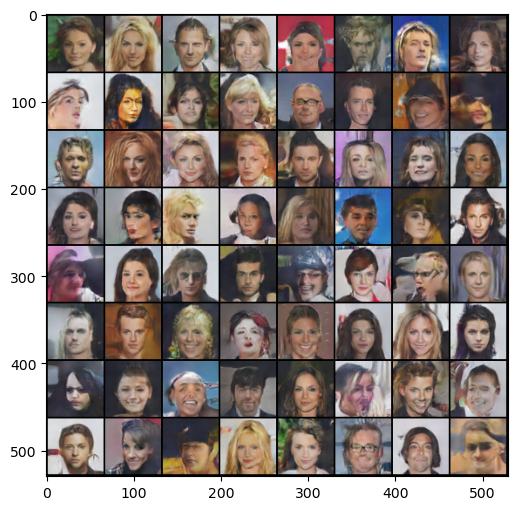

In [24]:
##model_version = "version_0"
#12
#checkpoint_path = next(Path(f"kaggle/working/logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))
#lit = GAN(generator, discriminator, discriminator_period=3)
#lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])
images = lit.generate(n=64)
grid = torchvision.utils.make_grid(
    tensor=images,
    nrow=8,
    padding=2,
    normalize=True,
    value_range=(-1, 1),
)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.transforms.ToPILImage()(grid))

#### Задание 3 (3+5 баллов). Более стабильные версии GAN

Модифицируйте вычисление ошибки для более стабильного обучения. 
- (3 балла) LSGAN (https://paperswithcode.com/method/lsgan)
- (5 балла) Wasserstein GAN + Gradient penalty (https://paperswithcode.com/method/wgan-gp)

Запустите обучение той же длительности, что в задании 2 (>50000 шагов, батч > 32) и сгенерируйте 64 изображения. Сравните результаты с заданием 2

#### Задание 4 (6 баллов). Донастройка

Выберите любой вариант GAN (vanilla GAN, LSGAN, Wasserstein GAN), но перед запуском длительного обучения поэкспериментируйте с настройками обучения, чтобы найти лучшую конфигурацию.

Для этого запустите не менее 3 предварительных сессий обучения на >30000 шагов и сгенерируйте примеры для всех запусков.

Главные настройки:
- learning rate оптимизаторов
- относительная частота обновления весов генератора и дискриминатора (можете изменить реализацию `training_step`, если хотите)
- архитектуры моделей: например, можете увеличить размеры моделей или докинуть слоёв

По результатам коротких запусков выберите удачную конфигурацию и запустите обучение на >100000 шагов, выведите примеры генерации в конце обучения